In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import random
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, optim
from torchvision import transforms
from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    loss_hist = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    pred = model(x).view(len(x), -1)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%50 == 0:
        loss_val, current = loss.item(), (batch + 1) * len(x)
        print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()

In [4]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x).view(len(x), -1)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [5]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
dataroot = 'gdrive/MyDrive/Colab Notebooks/digit-recognizer/'

In [7]:
df = pd.read_csv(dataroot + 'train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# train_df = df.sample(frac=0.9)
# test_df = df[~df.index.isin(train_df.index)]
train_df = df
test_df = df.sample(frac=0.3)

train_x = train_df.drop('label', axis=1)
train_y = train_df['label']

test_x = test_df.drop('label', axis=1)
test_y = test_df['label']

In [9]:
# transforming dataset to tensor type
train_x = torch.FloatTensor(np.reshape(np.array(train_x), (-1, 1, 28, 28)))
train_y = torch.LongTensor(np.array(train_y))

test_x = torch.FloatTensor(np.reshape(np.array(test_x), (-1, 1, 28, 28)))
test_y = torch.LongTensor(np.array(test_y))

tensor(1)


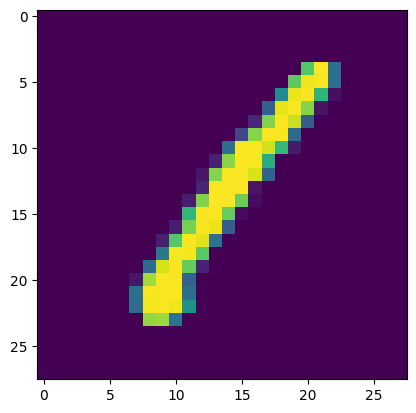

In [10]:
plt.imshow(train_x[0][0])
print(train_y[0])

In [11]:
training_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

In [12]:
batch_size = 128

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [13]:
device = ('cuda' if torch.cuda.is_available()
          else 'mps' if torch.backends.mps.is_available()
          else 'cpu')
print(f'device: {device}')

device: cuda


In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(2),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),
            nn.GELU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(2),
            nn.GELU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(2),
            nn.GELU(),
            nn.Conv2d(128, 10, 3, stride=3, padding=1),
        )
    def forward(self, x):
        x = self.main(x)
        return x

In [15]:
model = Net().to(device)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [17]:
num_epochs = 100

print('Start training loop')
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')
    train(train_dataloader, model, loss_fn, optimizer, scheduler)
    test(test_dataloader, model, loss_fn)
print('Done')

Start training loop
Epoch 1
-------------------------------
loss: 2.297260  [  128/42000]
loss: 2.034376  [ 6528/42000]
loss: 1.669813  [12928/42000]
loss: 1.128746  [19328/42000]
loss: 0.906016  [25728/42000]
loss: 0.692586  [32128/42000]
loss: 0.432561  [38528/42000]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.466300 

Epoch 2
-------------------------------
loss: 0.450079  [  128/42000]
loss: 0.303632  [ 6528/42000]
loss: 0.291227  [12928/42000]
loss: 0.199364  [19328/42000]
loss: 0.278147  [25728/42000]
loss: 0.219913  [32128/42000]
loss: 0.139872  [38528/42000]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.239866 

Epoch 3
-------------------------------
loss: 0.222291  [  128/42000]
loss: 0.153076  [ 6528/42000]
loss: 0.148742  [12928/42000]
loss: 0.120190  [19328/42000]
loss: 0.195423  [25728/42000]
loss: 0.133836  [32128/42000]
loss: 0.087449  [38528/42000]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.162831 

Epoch 4
-------------------------------
loss: 0.160175  [  128/42000]
loss

In [18]:
def make_submission(x, model, y_label, sample, submission_path):
    prediction = np.argmax(model(x).view(len(x), -1).cpu().detach().numpy(), axis=1)
    submission = sample.copy()
    submission[y_label] = prediction
    submission.to_csv(submission_path, index=False)

In [19]:
valid_df = pd.read_csv(dataroot + 'test.csv')

valid_x = torch.FloatTensor(np.reshape(np.array(valid_df), (-1, 1, 28, 28))).to(device)

In [20]:
y_label = 'Label'
sample = pd.read_csv(dataroot + 'sample_submission.csv')

submission_path = dataroot + 'submission.csv'

make_submission(valid_x, model, y_label, sample, submission_path)